In [40]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR
import numpy as np
import re
import os
import json
import math
import base64
from scipy.ndimage import interpolation as inter

import matplotlib.pyplot as plt


imgsz = 640

model = YOLO('./runs/segment/train3/weights/best.pt')
ocr = PaddleOCR(
    ocr_version='PP-OCRv5',
    use_doc_orientation_classify=True, 
    use_doc_unwarping=False, 
    use_textline_orientation=True
    )

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /home/coco/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /home/coco/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /home/coco/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /home/coco/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [47]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return best_angle, corrected

def calculate_aspect_ratio(width, height):
    gcd = math.gcd(int(width), int(height))
    simplified_width = int(width) // gcd
    simplified_height = int(height) // gcd
    return f"{simplified_width}:{simplified_height}", simplified_width / simplified_height

def aspect_ratio_distance(ratio, target_ratio=82/57):
    return abs(ratio - target_ratio)

def find_mask_corners(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)
        if len(approx) == 4:
            return approx.reshape(4, 2).astype(np.float32)
        else:
            rect = cv2.minAreaRect(largest_contour)
            box = cv2.boxPoints(rect)
            return box.astype(np.float32)
    return None

def evaluate_mask_shape(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    shape_score = 0
    if len(approx) == 4:
        shape_score += 10
    area = cv2.contourArea(largest_contour)
    hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(hull)
    if hull_area > 0:
        solidity = area / hull_area
        shape_score += solidity * 5
    perimeter = cv2.arcLength(largest_contour, True)
    if perimeter > 0:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        rectangularity = 1 - circularity
        shape_score += rectangularity * 3
    return shape_score

def calculate_mask_area(mask):
    return np.sum(mask)

def is_four_sided_shape(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return False
    largest_contour = max(contours, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, epsilon, True)
    return len(approx) == 4

def check_minimum_width(mask, min_width=20):
    mask_coords = np.where(mask)
    if len(mask_coords[0]) > 0:
        min_x, max_x = np.min(mask_coords[1]), np.max(mask_coords[1])
        width = max_x - min_x + 1
        return width >= min_width
    return False

def meets_mandatory_requirements(mask, max_aspect_distance=0.5):
    if not is_four_sided_shape(mask):
        return False, "Not 4-sided"
    if not check_minimum_width(mask):
        return False, "Width < 20px"
    mask_coords = np.where(mask)
    if len(mask_coords[0]) == 0:
        return False, "Empty mask"
    min_y, max_y = np.min(mask_coords[0]), np.max(mask_coords[0])
    min_x, max_x = np.min(mask_coords[1]), np.max(mask_coords[1])
    mask_width = max_x - min_x + 1
    mask_height = max_y - min_y + 1
    # aspect_str, aspect_float = calculate_aspect_ratio(mask_width, mask_height)
    # distance = aspect_ratio_distance(aspect_float)
    # if distance > max_aspect_distance:
    #     return False, f"Aspect ratio too far: {aspect_str}"
    return True, "Valid"

def order_points(pts):
    rect = np.zeros((4, 2), dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


In [65]:
def process_image(img_data):
    try:
        nparr = np.frombuffer(base64.b64decode(img_data), np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = original_rgb.shape[:2]
        
        results = model(cv2.resize(img.copy(), (imgsz, imgsz)), verbose=False, conf=0.4, device='cuda')
        ocr_results = []
        
        if results[0].masks is not None:

            boxes = [[x1, y1, x2, y2, score] for x1, y1, x2, y2, score, _ in results[0].boxes.data.tolist()]
            mask_indices = np.argsort([mask[0][0] for mask in results[0].masks.data.tolist()])
            box_indices = np.argsort([box[0] for box in boxes])
            index_mapping = dict(zip(box_indices, range(len(boxes))))
            tracked_masks = [results[0].masks.data.tolist()[mask_indices[index_mapping[i]]] 
                            for i in range(len(boxes)) if i in index_mapping]

            
            for mask_idx, (box, mask) in enumerate(zip(boxes, tracked_masks)):
                
                xyxy = np.array(box[:4])
                x1, y1, x2, y2 = map(int, xyxy)
                scale_x, scale_y = w / imgsz, h / imgsz
                x1, y1, x2, y2 = int(x1 * scale_x), int(y1 * scale_y), int(x2 * scale_x), int(y2 * scale_y)
                
                padding = 50
                x1_pad = max(0, x1 - padding)
                y1_pad = max(0, y1 - padding)
                x2_pad = min(w, x2 + padding)
                y2_pad = min(h, y2 + padding)
                
                cropped_no_pad = original_rgb[y1:y2, x1:x2]
                if cropped_no_pad.size == 0:
                    continue
                
                mask_data = np.array(mask[:-2])
                enhanced_mask = mask_data > 0.5
                is_valid, reason = meets_mandatory_requirements(enhanced_mask)
                
                if is_valid:
                    mask_coords = np.where(enhanced_mask)
                    min_y, max_y = np.min(mask_coords[0]), np.max(mask_coords[0])
                    min_x, max_x = np.min(mask_coords[1]), np.max(mask_coords[1])
                    mask_width = max_x - min_x + 1
                    mask_height = max_y - min_y + 1
                    aspect_str, aspect_float = calculate_aspect_ratio(mask_width, mask_height)
                    # distance = aspect_ratio_distance(aspect_float)
                    shape_score = evaluate_mask_shape(enhanced_mask)
                    area = calculate_mask_area(enhanced_mask)
                    # valid_candidate = {'mask': enhanced_mask, 'image': original_rgb, 'name': 'full', 'distance': distance, 'shape_score': shape_score, 'area': area}
                    valid_candidate = {'mask': enhanced_mask, 'image': original_rgb, 'name': 'full', 'shape_score': shape_score, 'area': area}
                else:
                    valid_candidate = None
                
                if valid_candidate is None:
                    working_image = cv2.cvtColor(cropped_no_pad, cv2.COLOR_RGB2BGR)
                else:
                    # corners = find_mask_corners(valid_candidate['mask'])
                    # if corners is not None:
                    #     ordered_corners = order_points(corners)
                    #     width = int(max(np.linalg.norm(ordered_corners[1] - ordered_corners[0]), np.linalg.norm(ordered_corners[2] - ordered_corners[3])))
                    #     height = int(max(np.linalg.norm(ordered_corners[3] - ordered_corners[0]), np.linalg.norm(ordered_corners[2] - ordered_corners[1])))
                    #     dst_corners = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)
                    #     M = cv2.getPerspectiveTransform(ordered_corners, dst_corners)
                    #     warped = cv2.warpPerspective(valid_candidate['image'], M, (width, height))
                    #     working_image = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
                    # else:
                    working_image = cv2.cvtColor(cropped_no_pad, cv2.COLOR_RGB2BGR)

                _, corrected_bgr = correct_skew(working_image)
                final_gray = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2GRAY)
                _, thresholded = cv2.threshold(final_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                try:
                    final_img = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
                    result = ocr.predict(final_img)
                    if result and result[0]:
                        ocr_texts = result[0].get('rec_texts', [])
                        confidences = result[0].get('rec_scores', [])
                        
                        if ocr_texts:
                            # ocr_text = " ".join(ocr_texts)
                            # avg_confidence = sum(confidences) / len(confidences) if confidences else 0

                            for ocr_text, conf in zip(ocr_texts, confidences):
                                # ocr_text = re.sub(r'[^A-Za-z0-9\s]', '', ocr_text).strip()
                                if len(ocr_text) >= 3:
                                    ocr_results.append({'text': ocr_text, 'confidence': conf,})
                        else:
                            continue
                    else:
                        ocr_text = ""
                        avg_confidence = 0
                except Exception as e:
                    ocr_text = f"ERROR: {str(e)[:30]}"
                    avg_confidence = 0

                # ocr_results.append({'text': ocr_text, 'confidence': avg_confidence,})
        
        return {'success': True, 'results': ocr_results}
        
    except Exception as e:
        return {'success': False, 'error': str(e)}

In [66]:
# img_path = './datasets/valid/images/ds1_0000_jpg.rf.4eae7fa15bbb753677b864a8c8437835.jpg'
# img_path = './6163206443046652006.jpg'
img_path = './sg-11134207-7rcda-lri9ci2lu1wo0e.jpg'

img = base64.b64encode(open(img_path, 'rb').read()).decode('utf-8')

process_image(img)


/tmp/ipykernel_287795/1324014784.py:3: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = inter.rotate(arr, angle, reshape=False, order=0)


{'success': True,
 'results': [{'text': 'NAME SURNAME', 'confidence': 0.98024582862854},
  {'text': 'JOB POSITION', 'confidence': 0.9643695950508118},
  {'text': '+0123 456 789', 'confidence': 0.9298632740974426},
  {'text': 'name@companyname.com', 'confidence': 0.982434868812561},
  {'text': 'www.companyname.com', 'confidence': 0.9939028024673462},
  {'text': 'address line here', 'confidence': 0.9657682776451111}]}

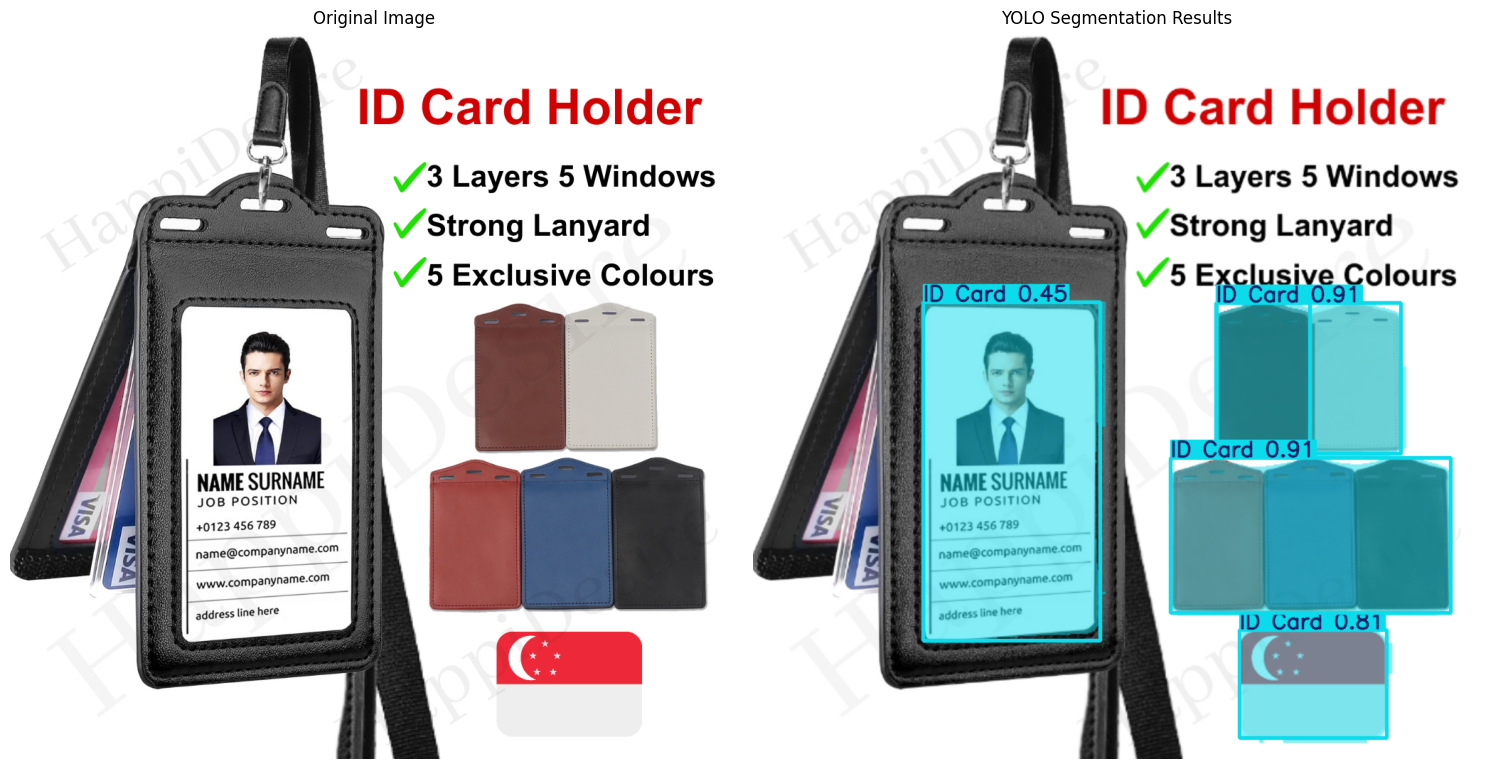

Detected 5 objects
Generated 5 masks
Confidence scores: [0.9059305787086487, 0.9058251976966858, 0.8081079125404358, 0.45052167773246765, 0.2959884703159332]
Class IDs: [1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
# image_path = './sg-11134207-7rcda-lri9ci2lu1wo0e.jpg'
# results = model(image_path)

# img = cv2.imread(image_path)
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# plt.figure(figsize=(15, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(img_rgb)
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# annotated_img = results[0].plot()
# annotated_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
# plt.imshow(annotated_rgb)
# plt.title('YOLO Segmentation Results')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# for result in results:
#     print(f"Detected {len(result.boxes)} objects")
#     if result.masks is not None:
#         print(f"Generated {len(result.masks)} masks")
#     print(f"Confidence scores: {result.boxes.conf.tolist()}")
#     print(f"Class IDs: {result.boxes.cls.tolist()}")